<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting a movie review sentiment model with LIME
This notebook demonstrates the use of DIANNA with the LIME method on the [Stanford Sentiment Treebank dataset](https://nlp.stanford.edu/sentiment/index.html) which contains one-sentence movie reviews. See also [their paper](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf). A pre-trained neural network classifier is used, which identifies whether a movie review is positive or negative.

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 1. Imports and paths

In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import spacy
from torchtext.vocab import Vectors
from scipy.special import expit as sigmoid

import dianna
from dianna import visualization
from dianna import utils
from dianna.utils.tokenizers import SpacyTokenizer

root_dir = Path(dianna.__file__).parent

/home/elenar/.local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/elenar/.local/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/elenar/.local/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /

In [3]:
model_path = Path(root_dir, 'models', 'movie_review_model.onnx')
word_vector_path = Path(root_dir, 'data', 'movie_reviews_word_vectors.txt')
labels = ("negative", "positive")

#### 2. Loading the model

The classifier is stored in ONNX format. It accepts numerical tokens as input, and outputs a score between 0 and 1, where 0 means the review is negative and 1 that it is positive.  
Here we define a class to run the model, which accepts a sentence (i.e. string) as input instead and returns two classes: negative and positive.

In [4]:
# ensure the tokenizer for english is available
spacy.cli.download('en_core_web_sm')

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
class MovieReviewsModelRunner:
    def __init__(self, model, word_vectors, max_filter_size):
        self.run_model = utils.get_function(model)
        self.vocab = Vectors(word_vectors, cache=os.path.dirname(word_vectors))
        self.max_filter_size = max_filter_size
        
        self.tokenizer = SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        output = []
        for sentence in sentences:
            # tokenize and pad to minimum length
            tokens = self.tokenizer.tokenize(sentence.lower())
            if len(tokens) < self.max_filter_size:
                tokens += ['<pad>'] * (self.max_filter_size - len(tokens))
            
            # numericalize the tokens
            tokens_numerical = [self.vocab.stoi[token] if token in self.vocab.stoi else self.vocab.stoi['<unk>']
                                for token in tokens]

            # run the model, applying a sigmoid because the model outputs logits, remove any remaining batch axis
            pred = float(sigmoid(self.run_model([tokens_numerical])))
            output.append(pred)

        # output two classes
        positivity = np.array(output)
        negativity = 1 - positivity
        return np.transpose([negativity, positivity])       

In [6]:
# define model runner. max_filter_size is a property of the model
model_runner = MovieReviewsModelRunner(model_path, word_vector_path, max_filter_size=5)

#### 3. Applying LIME with DIANNA
The simplest way to run DIANNA on text data is with `dianna.explain_text`. The arguments are:
* The function that runs the model (a path to a model in ONNX format is also accepted)
* The text we want to explain
* The name of the explainable-AI method we want to use, here LIME
* The numerical index of the class we want an explanation for

`dianna.explain_text` returns a list of tuples. Each tuple contains a word, its location in the input text, and its importance for the selected output class

In [7]:
review = "A delectable and intriguing thriller filled with surprises."

In [8]:
# We're getting the explanation for the 'positive' class only,
# but dianna supports explaining for multiple labels in one go.
# It therefore always outputs a list of saliency maps. We want
# the first and only saliency map from this list here.
explanation_relevance = dianna.explain_text(model_runner, review, model_runner.tokenizer,
                                            'LIME', labels=[labels.index('positive')])[0]
explanation_relevance

/tmp/ipykernel_148274/1753736335.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))


[('intriguing', 3, 0.15106371941273863),
 ('thriller', 4, 0.0666621299014461),
 ('delectable', 1, 0.05862722985325546),
 ('and', 2, 0.017196107084681462),
 ('A', 0, 0.016858394086566746),
 ('with', 6, 0.01555234692715039),
 ('filled', 5, -0.012708497462152451),
 ('surprises', 7, 0.004439451941227339),
 ('.', 8, 0.00308639465869986)]

#### 4. Visualization
DIANNA includes a visualization package, capable of highlighting the relevance of each word in the text for a chosen class. The visualization is in HTML format.
Words in favour of the selected class are highlighted in red, while words against the selected class - in blue.

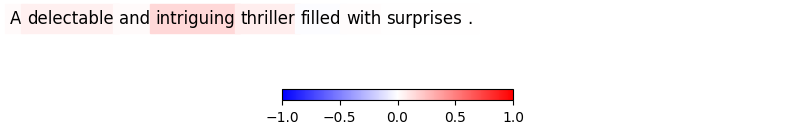

In [9]:
fig, _ = visualization.highlight_text(explanation_relevance, model_runner.tokenizer.tokenize(review))

The most important word for this review being classified as positive is "intriguing", followed by "delectable" and "thriller".


#### Trying more text explanations

And what are the words' relevancies to a '**negative**' classification decision?

In [10]:
explanation_relevance = dianna.explain_text(model_runner, review, model_runner.tokenizer,
                                            'LIME', labels=[labels.index('negative')])[0]
explanation_relevance

/tmp/ipykernel_148274/1753736335.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))


[('intriguing', 3, -0.14700584256064306),
 ('thriller', 4, -0.06629932673165247),
 ('delectable', 1, -0.058852972635309087),
 ('and', 2, -0.01845355412506968),
 ('A', 0, -0.018352342085130487),
 ('with', 6, -0.01574308535742077),
 ('filled', 5, 0.009444203455115149),
 ('surprises', 7, -0.002333283066043112),
 ('.', 8, -0.000547770626673327)]

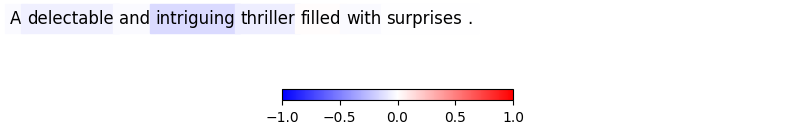

In [11]:
fig, _ = visualization.highlight_text(explanation_relevance, model_runner.tokenizer.tokenize(review))

And what about a harder to classify review with mixed words, but still a clear overall sentiment?

In [12]:
mixed_review = 'The movie started great but the ending is boring and unoriginal!'

In [13]:
explanation_relevance = dianna.explain_text(model_runner, mixed_review, model_runner.tokenizer,
                                            'LIME', labels=[labels.index('negative')])[0]
explanation_relevance

/tmp/ipykernel_148274/1753736335.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))


[('boring', 8, 0.44884226182084497),
 ('great', 3, -0.22322271913393144),
 ('ending', 6, 0.10510269927151149),
 ('!', 11, 0.10183168555208075),
 ('unoriginal', 10, 0.05655987107183151),
 ('movie', 1, -0.03639735890933897),
 ('is', 7, 0.032529050086177305),
 ('the', 5, -0.025896513883823795),
 ('and', 9, 0.011733854130573068),
 ('but', 4, 0.010511020813695787)]

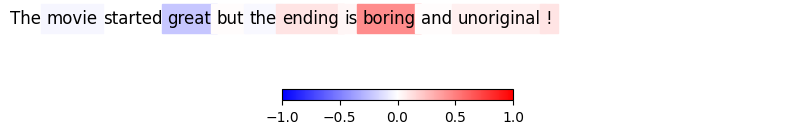

In [15]:
fig, _ = visualization.highlight_text(explanation_relevance, model_runner.tokenizer.tokenize(mixed_review))

Indeed, "boring" and "unoriginal" are the words carrying the overall negative sentiment, hence they contribute most toward that decision, while "great" being a positive word, contributes negatively towards the classificator's decision!